# 이진분류 기준으로 C/D 예측 정확도 향상목적

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Pretendard'  # Windows용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

In [2]:
import pandas as pd

# 파일 경로
file_path = "../../data/통합_train_데이터.parquet"
df = pd.read_parquet(file_path)

In [3]:
top_cde = ['이용금액_일시불_R3M',
 '이용금액_R3M_신용체크',
 '정상입금원금_B0M',
 '이용금액_오프라인_R6M',
 '정상청구원금_B0M',
 '이용건수_신용_R6M',
 '이용금액_오프라인_R3M',
 '이용건수_일시불_R12M',
 '_1순위카드이용금액',
 '이용금액_오프라인_B0M',
 '청구금액_R3M',
 '이용금액_일시불_R12M',
 '이용금액_R3M_신용',
 '정상입금원금_B5M',
 '이용건수_오프라인_B0M',
 '정상청구원금_B2M',
 '이용건수_신판_R12M',
 '청구금액_B0',
 '정상입금원금_B2M',
 '이용금액_일시불_B0M',
 '정상청구원금_B5M',
 '청구금액_R6M',
 '최대이용금액_일시불_R12M',
 '이용가맹점수',
 '이용건수_신용_R12M',
 '이용금액_일시불_R6M']

In [4]:
# 📌 PC1~PC5에서 반복적으로 중요한 변수:
pca_cols = [
    'CA이자율_할인전', 'CL이자율_할인전', 'RV_평균잔액_R3M', 'RV일시불이자율_할인전', 'RV최소결제비율', 'RV현금서비스이자율_할인전', 
    '방문월수_앱_R6M', '방문일수_앱_B0M', '방문일수_앱_R6M', '방문횟수_앱_B0M', '방문후경과월_앱_R6M', 
    '이용금액_R3M_신용', '이용금액_R3M_신용체크', '이용금액_일시불_B0M', '이용금액대', 
    '일시불ONLY전환가능여부', 
    '잔액_리볼빙일시불이월_B0M', '잔액_일시불_B0M', '잔액_일시불_B1M', '잔액_일시불_B2M', '잔액_카드론_B0M', '잔액_카드론_B1M', '잔액_카드론_B2M', '잔액_카드론_B3M', '잔액_카드론_B4M', '잔액_카드론_B5M', 
    '정상청구원금_B0M', '정상청구원금_B2M', '정상청구원금_B5M', 
    '청구금액_B0', '청구금액_R3M', '청구금액_R6M', '최종카드론_대출금액', '카드론이용금액_누적', '평잔_RV일시불_3M', '평잔_RV일시불_6M', '평잔_일시불_3M', '평잔_일시불_6M', 
    '평잔_카드론_3M', '평잔_카드론_6M', '평잔_할부_3M', '홈페이지_금융건수_R3M', '홈페이지_금융건수_R6M', '홈페이지_선결제건수_R3M', '홈페이지_선결제건수_R6M'
    ]

In [5]:
print(len(pca_cols))

45


In [6]:
# 기본적으로 필요한 컬럼
base_cols = ['ID', 'Segment']
all_selected_cols = list(set(base_cols + selected_cols))

In [7]:
def map_categorical_columns(df, verbose=True):
    """
    미리 정의된 매핑 기준에 따라 범주형 컬럼들을 수치형으로 변환합니다.
    처리 컬럼: 거주시도명, 연회비발생카드수_B0M, 한도증액횟수_R12M, 이용금액대,
              할인건수_R3M, 할인건수_B0M, 방문횟수_PC_R6M, 방문횟수_앱_R6M, 방문일수_PC_R6M
    """

    # 1. 거주시도명 → 수도권 여부
    capital_area = ['서울', '경기', '인천']
    if '거주시도명' in df.columns:
        df['거주시도명'] = df['거주시도명'].apply(lambda x: 1 if x in capital_area else 0)

    # 2. 연회비발생카드수_B0M
    mapping = {"0개": 0, "1개이상": 1}
    if '연회비발생카드수_B0M' in df.columns:
        df['연회비발생카드수_B0M'] = df['연회비발생카드수_B0M'].map(mapping).astype(int)
        if verbose: print("[연회비발생카드수_B0M] 인코딩 완료")

    # 3. 한도증액횟수_R12M
    mapping = {"0회": 0, "1회이상": 1}
    if '한도증액횟수_R12M' in df.columns:
        df['한도증액횟수_R12M'] = df['한도증액횟수_R12M'].map(mapping).astype(int)
        if verbose: print("[한도증액횟수_R12M] 인코딩 완료")

    # 4. 이용금액대 (중간값 기준: 만원 단위)
    mapping = {
        "09.미사용": 0,
        "05.10만원-": 5,
        "04.10만원+": 20,
        "03.30만원+": 40,
        "02.50만원+": 75,
        "01.100만원+": 150
    }
    if '이용금액대' in df.columns:
        df['이용금액대'] = df['이용금액대'].map(mapping)
        if verbose: print("[이용금액대] 중간값 인코딩 완료")

   # 5. 할인건수 인코딩
    discount_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40
    }
    for col in ['할인건수_R3M', '할인건수_B0M']:
        if col in df.columns:
            df[col] = df[col].map(discount_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    # 6. 방문횟수 및 방문일수 인코딩
    visit_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40,
        "50회 이상": 50,
        "60회 이상": 60,
        "70회 이상": 70,
        "80회 이상": 80
    }

    visit_cols = ['방문횟수_PC_R6M', '방문횟수_앱_R6M', '방문일수_PC_R6M']
    for col in visit_cols:
        if col in df.columns:
            df[col] = df[col].map(visit_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    return df

In [8]:
df = map_categorical_columns(df)

[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
[방문횟수_PC_R6M] 인코딩 완료
[방문횟수_앱_R6M] 인코딩 완료
[방문일수_PC_R6M] 인코딩 완료


In [11]:
selected_feature=(top_cde + pca_cols)
selected_feature = list(dict.fromkeys(selected_feature))

## 전체모델링 시도 (CDE 피처)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


# 2. 피처 및 타겟 분리
X = df[selected_feature].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. 학습
xgb_model.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:19:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [12:20:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.88      0.15      0.26       194
           1       1.00      0.21      0.34        29
           2       0.71      0.55      0.62     25518
           3       0.67      0.60      0.63     69848
           4       0.93      0.96      0.95    384411

    accuracy                           0.89    480000
   macro avg       0.84      0.49      0.56    480000
weighted avg       0.88      0.89      0.88    480000



## SHAP 확인

| 정확도 향상을 위해서 샘플수 1000개로 늘림

100%|===================| 968/970 [00:46<00:00]        

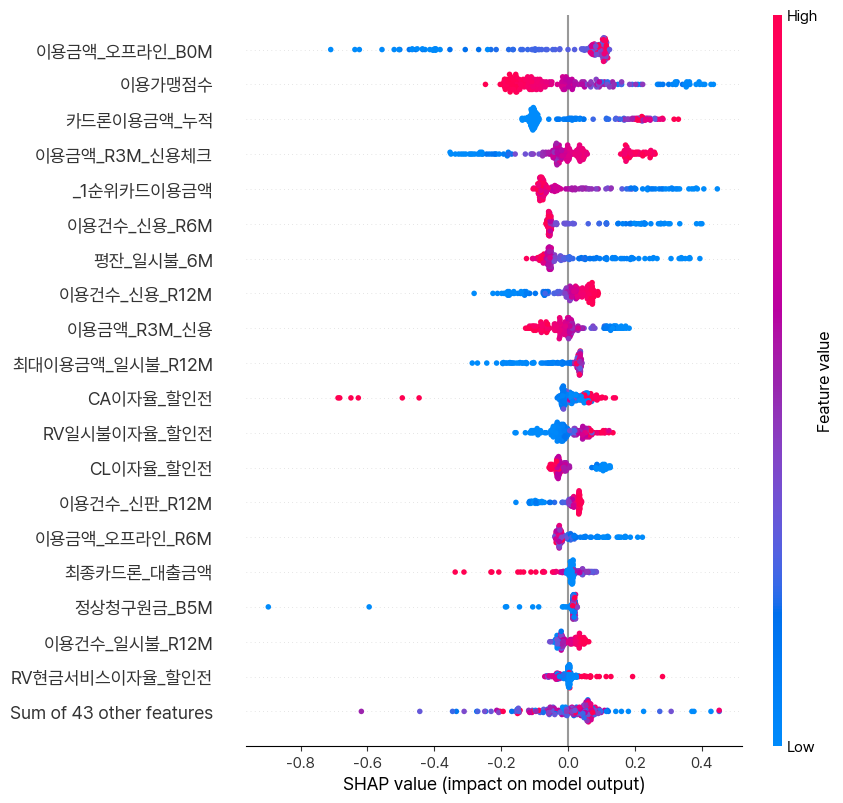

In [13]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 1000)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

# SHAP plot (2D shap값만 전달해야 함)
shap.plots.beeswarm(shap_values_0[:, :, 2], max_display=20)

 99%|===================| 961/970 [00:46<00:00]        

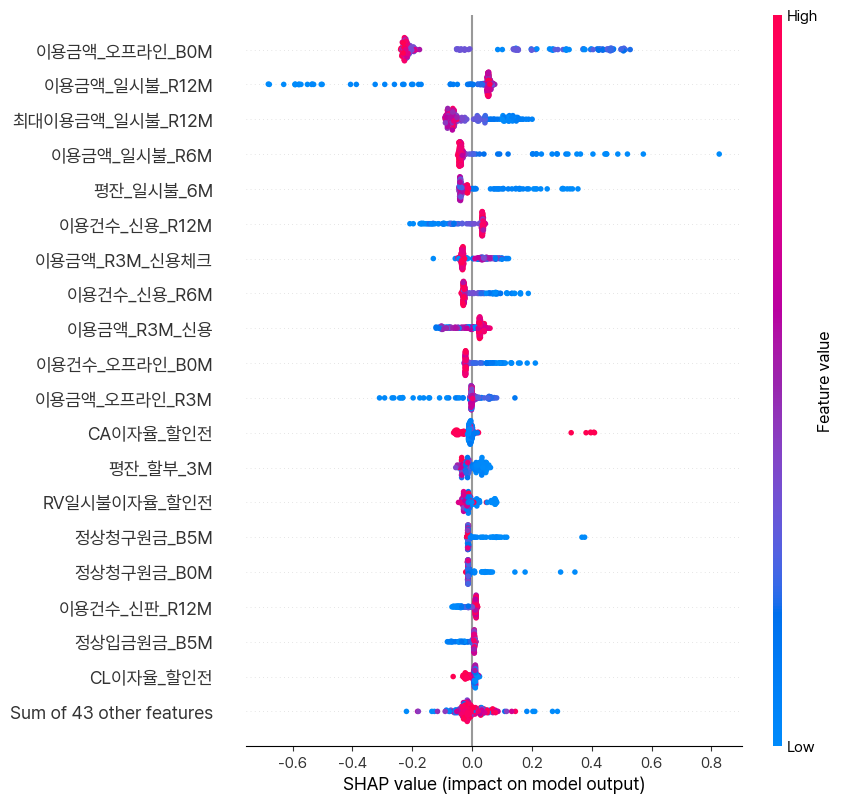

In [14]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 1000)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

# SHAP plot (2D shap값만 전달해야 함)
shap.plots.beeswarm(shap_values_0[:, :, 3], max_display=20)

### PCA 결과 참고

📌 PC3 기여도 높은 피처:
평잔_카드론_3M             0.228114
평잔_카드론_6M             0.226489
잔액_카드론_B1M            0.225993
잔액_카드론_B2M            0.225915
잔액_카드론_B3M            0.224775
잔액_카드론_B0M            0.224503
잔액_카드론_B4M            0.222100
잔액_카드론_B5M            0.218111
카드론이용금액_누적            0.173326
최종카드론_대출금액            0.158909
잔액_신판평균한도소진율_r6m      0.157496
잔액_신판평균한도소진율_r3m      0.155220
잔액_신판최대한도소진율_r3m      0.152528
잔액_신판최대한도소진율_r6m      0.149643
잔액_신판ca평균한도소진율_r6m    0.149578
dtype: float64

📌 PC4 기여도 높은 피처:
평잔_RV일시불_3M        0.197668
평잔_RV일시불_6M        0.196758
RV_평균잔액_R3M        0.193185
잔액_할부_B0M          0.192133
잔액_할부_B1M          0.188427
잔액_리볼빙일시불이월_B0M    0.188243
평잔_할부_3M           0.187681
잔액_할부_B2M          0.185366
평잔_할부_6M           0.182692
잔액_일시불_B1M         0.174527
잔액_일시불_B2M         0.173784
잔액_할부_무이자_B0M      0.172555
잔액_일시불_B0M         0.169276
평잔_일시불_3M          0.166159
평잔_일시불_6M          0.162657
dtype: float64

In [15]:
cd_cardloan_features = [
    '평잔_카드론_3M', '평잔_카드론_6M', '잔액_카드론_B1M', '잔액_카드론_B2M',
    '잔액_카드론_B3M', '잔액_카드론_B0M', '잔액_카드론_B4M', '잔액_카드론_B5M',
    '카드론이용금액_누적', '최종카드론_대출금액',
    '잔액_신판평균한도소진율_r6m', '잔액_신판평균한도소진율_r3m',
    '잔액_신판최대한도소진율_r3m', '잔액_신판최대한도소진율_r6m',
    '잔액_신판ca평균한도소진율_r6m'
]

cd_installment_features = [
    '평잔_RV일시불_3M', '평잔_RV일시불_6M', 'RV_평균잔액_R3M',
    '잔액_할부_B0M', '잔액_할부_B1M', '잔액_리볼빙일시불이월_B0M',
    '평잔_할부_3M', '잔액_할부_B2M', '평잔_할부_6M',
    '잔액_일시불_B1M', '잔액_일시불_B2M', '잔액_할부_무이자_B0M',
    '잔액_일시불_B0M', '평잔_일시불_3M', '평잔_일시불_6M'
]

In [16]:
selected_feature=(top_cde + pca_cols + cd_cardloan_features + cd_installment_features)
selected_feature = list(dict.fromkeys(selected_feature))

In [17]:
# 2. 피처 및 타겟 분리
X = df[selected_feature].copy()
y = df["Segment"]

# 3. 범주형 인코딩
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 결측치 처리
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# 스케일링 (DataFrame 형태 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 라벨인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation 분할
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost 모델 선언 (GPU 가속)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. 학습
xgb_model.fit(X_train, y_train)

# 9. 예측 및 평가
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:31:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:31:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [12:32:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.83      0.20      0.32       194
           1       1.00      0.24      0.39        29
           2       0.71      0.56      0.62     25518
           3       0.68      0.60      0.64     69848
           4       0.93      0.97      0.95    384411

    accuracy                           0.89    480000
   macro avg       0.83      0.51      0.58    480000
weighted avg       0.88      0.89      0.89    480000



### E 제외 모델링

In [19]:
# 세그먼트가 A, B, C, D만 포함되도록 필터링
mask_abcd = df['Segment'].isin(['A', 'B', 'C', 'D'])
X_abcd = df.loc[mask_abcd, selected_feature]
y_abcd = df.loc[mask_abcd, 'Segment']

In [22]:
from sklearn.preprocessing import LabelEncoder

# 문자형 Segment → 숫자형 인코딩
le_abcd = LabelEncoder()
y_abcd_encoded = le_abcd.fit_transform(y_abcd)  # ['A', 'B', 'C', 'D'] → [0, 1, 2, 3]

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_abcd, y_abcd_encoded, test_size=0.2, stratify=y_abcd_encoded, random_state=42
)

xgb_model.fit(X_train, y_train)

# 모델 학습
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:35:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:35:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:35:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [12:36:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


              precision    recall  f1-score   support

           0       0.86      0.23      0.36       194
           1       1.00      0.17      0.29        29
           2       0.77      0.60      0.67     25518
           3       0.86      0.94      0.90     69849

    accuracy                           0.84     95590
   macro avg       0.87      0.48      0.56     95590
weighted avg       0.84      0.84      0.84     95590



In [26]:
from sklearn.metrics import f1_score

# y_true: 실제 정답 (e.g., y_val)
# y_pred: 모델이 예측한 값

f1_macro = f1_score(y_val, y_pred, average='macro')
f1_micro = f1_score(y_val, y_pred, average='micro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f"Macro F1-score:    {f1_macro:.4f}")
print(f"Micro F1-score:    {f1_micro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

Macro F1-score:    0.5563
Micro F1-score:    0.8450
Weighted F1-score: 0.8376


### SHAP 확인

 99%|===================| 770/776 [00:32<00:00]        

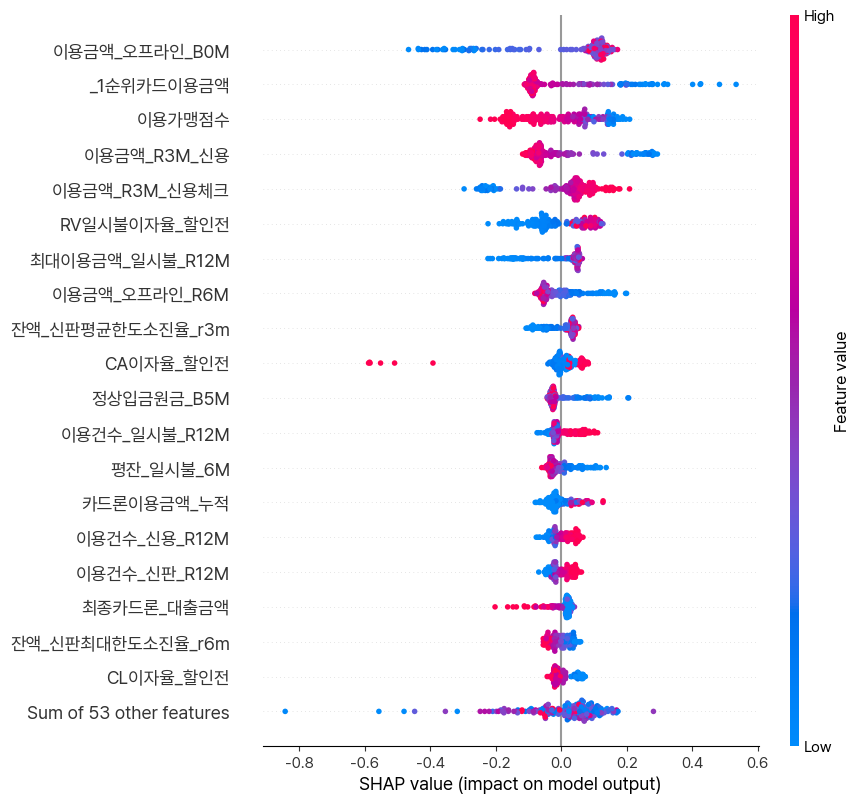

In [27]:
import shap  
import pandas as pd

# Segment 0 마스킹 + 데이터 준비
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# 샘플 수 조정
n_samples = min(len(X_val_0_all), 1000)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP 해석
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

# SHAP plot (2D shap값만 전달해야 함)
shap.plots.beeswarm(shap_values_0[:, :, 2], max_display=20)

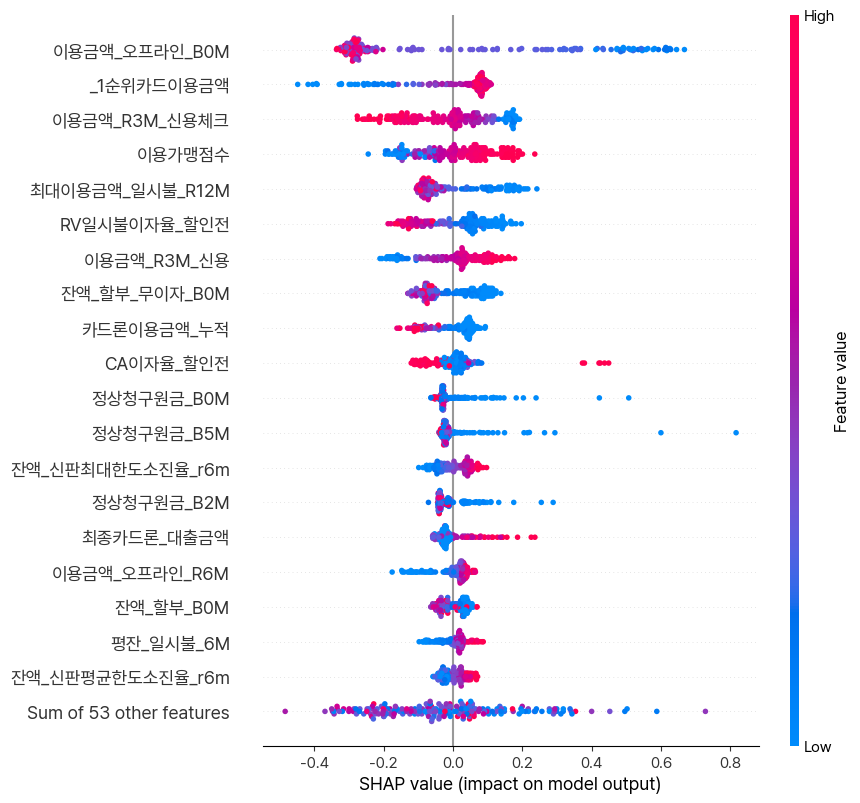

In [28]:
shap.plots.beeswarm(shap_values_0[:, :, 3], max_display=20)

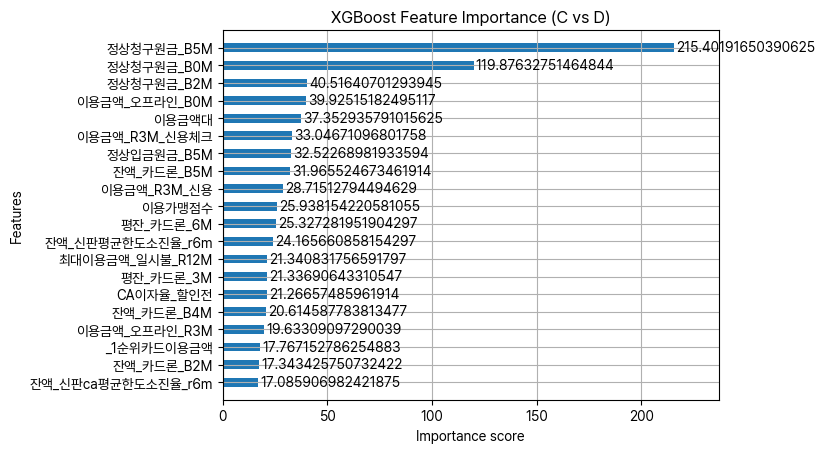

In [29]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 특성 중요도 시각화
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance (C vs D)")
plt.show()

100%|===================| 476564/476832 [32:20<00:01]        

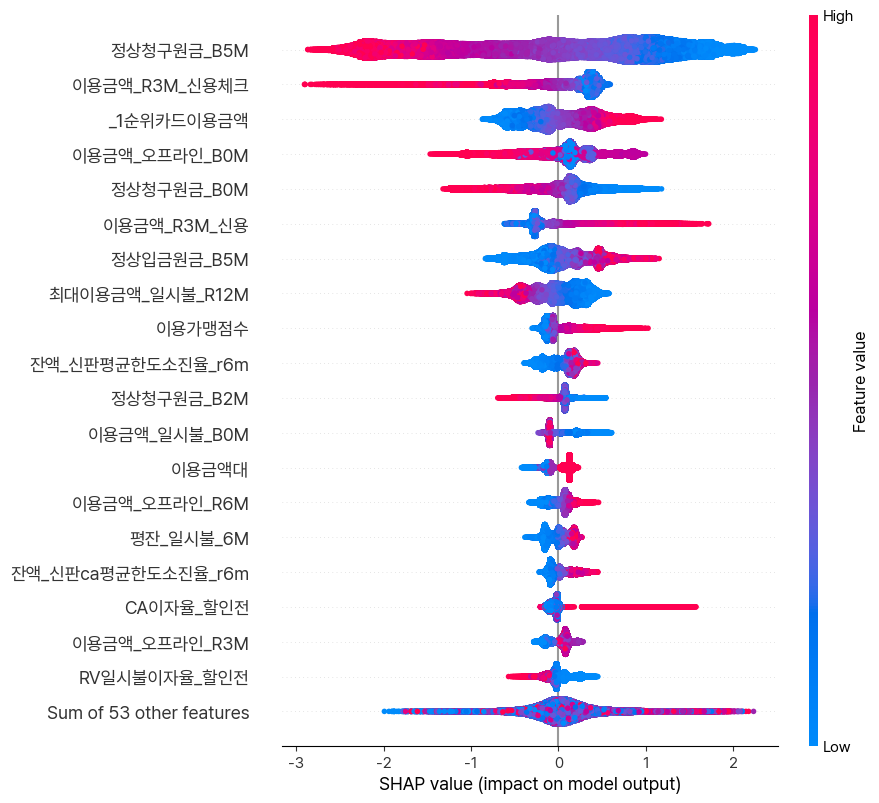

In [32]:
import shap

# Segment C와 D에 해당하는 데이터만 추출
mask_cd = df['Segment'].isin(['C', 'D'])
X_cd = df.loc[mask_cd, selected_feature]
y_cd = df.loc[mask_cd, 'Segment']

# 숫자형 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le_cd = LabelEncoder()
y_cd_encoded = le_cd.fit_transform(y_cd)  # 'C' → 0, 'D' → 1

# 모델 학습
from xgboost import XGBClassifier
xgb_cd = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
xgb_cd.fit(X_cd, y_cd_encoded)

# SHAP 해석
explainer = shap.Explainer(xgb_cd, X_cd)
shap_values_cd = explainer(X_cd)

# SHAP beeswarm plot
shap.plots.beeswarm(shap_values_cd, max_display=20)


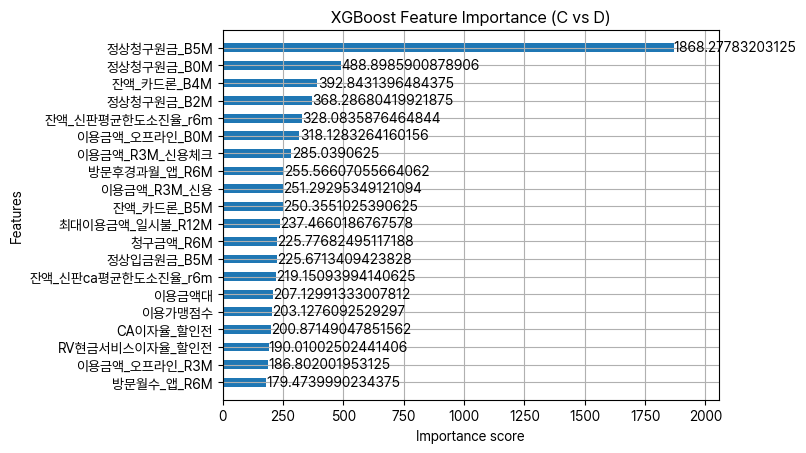

In [34]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 특성 중요도 시각화
xgb.plot_importance(xgb_cd, max_num_features=20, importance_type='gain', height=0.5)
plt.title("XGBoost Feature Importance (C vs D)")
plt.show()

In [ ]:
# SHAP 기반 C, D Top 피처 선정
cd_top_features = [
    '정상청구원금_B5M',
    '이용금액_R3M_신용체크',
    '_1순위카드이용금액',
    '이용금액_오프라인_B0M',
    '정상청구원금_B0M',
    '이용금액_R3M_신용',
    '정상입금원금_B5M',
    '최대이용금액_일시불_R12M',
    '이용가맹점수',
    '잔액_신판평균한도소진율_r6m',
    '정상청구원금_B2M',
    '이용금액_일시불_B0M',
    '이용금액대',
    '이용금액_오프라인_R6M',
    '평잔_일시불_6M',
    '잔액_신판ca평균한도소진율_r6m',
    'CA이자율_할인전',
    '이용금액_오프라인_R3M',
    'RV일시불이자율_할인전'
]

### PCA 시각화

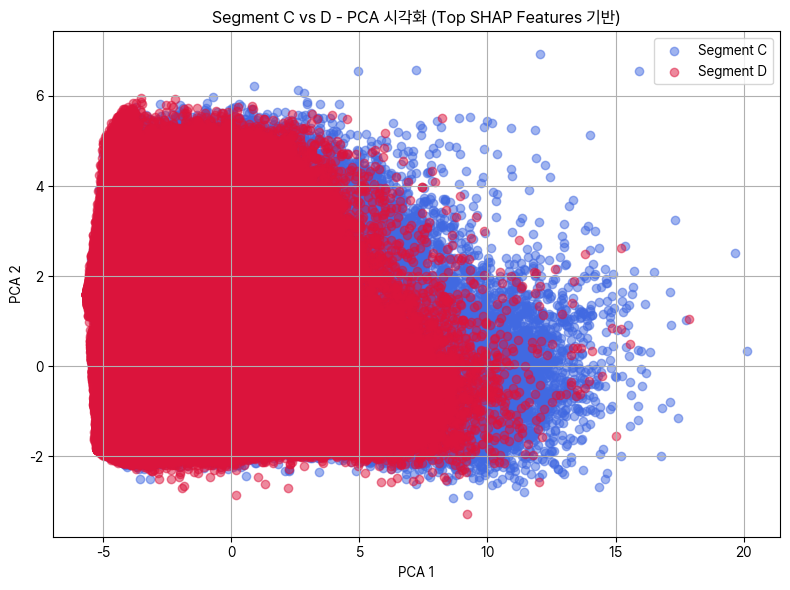

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# 1. Segment C/D만 추출
mask_cd = df['Segment'].isin(['C', 'D'])
X_cd = df.loc[mask_cd, cd_top_features].copy()
y_cd = df.loc[mask_cd, 'Segment'].copy()

# 2. 라벨 인코딩 (C=0, D=1)
le_cd = LabelEncoder()
y_cd_encoded = le_cd.fit_transform(y_cd)  # 'C' → 0, 'D' → 1

# 3. 스케일링
scaler = StandardScaler()
X_cd_scaled = scaler.fit_transform(X_cd)

# 4. PCA 변환
pca = PCA(n_components=2)
X_cd_pca = pca.fit_transform(X_cd_scaled)

# 5. 시각화
plt.figure(figsize=(8,6))
colors = ['royalblue', 'crimson']
labels = le_cd.classes_

for i, label in enumerate(labels):
    plt.scatter(X_cd_pca[y_cd_encoded == i, 0], X_cd_pca[y_cd_encoded == i, 1],
                alpha=0.5, label=f'Segment {label}', c=colors[i])

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Segment C vs D - PCA 시각화 (Top SHAP Features 기반)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LDA 시각화

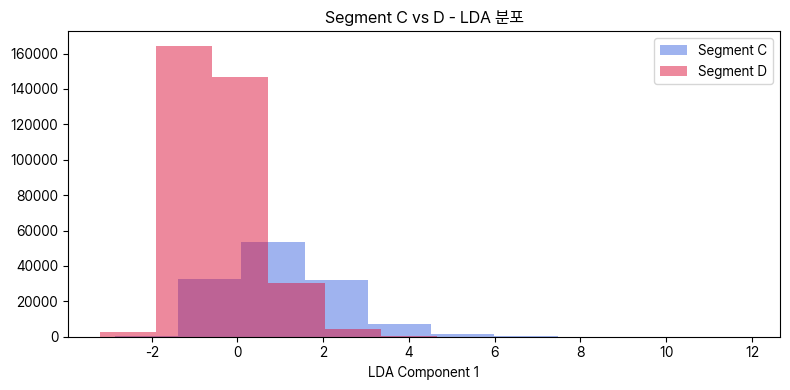

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_cd_lda = lda.fit_transform(X_cd_scaled, y_cd_encoded)

plt.figure(figsize=(8,4))
plt.hist(X_cd_lda[y_cd_encoded == 0], alpha=0.5, label='Segment C', color='royalblue')
plt.hist(X_cd_lda[y_cd_encoded == 1], alpha=0.5, label='Segment D', color='crimson')
plt.title("Segment C vs D - LDA 분포")
plt.xlabel("LDA Component 1")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 인코딩된 Segment C/D
X = df.loc[df['Segment'].isin(['C', 'D']), cd_top_features]
y = df.loc[df['Segment'].isin(['C', 'D']), 'Segment']
le_cd = LabelEncoder()
y_encoded = le_cd.fit_transform(y)

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [58]:
from xgboost import XGBClassifier

model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:15:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:15:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [14:15:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

In [59]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred, target_names=le_cd.classes_))

print("F1 Macro :", f1_score(y_val, y_pred, average='macro'))
print("F1 Micro :", f1_score(y_val, y_pred, average='micro'))
print("F1 Weighted :", f1_score(y_val, y_pred, average='weighted'))


              precision    recall  f1-score   support

           C       0.66      0.71      0.68     25518
           D       0.89      0.86      0.88     69849

    accuracy                           0.82     95367
   macro avg       0.77      0.79      0.78     95367
weighted avg       0.83      0.82      0.83     95367

F1 Macro : 0.7808546226437649
F1 Micro : 0.8236287185294704
F1 Weighted : 0.8258601633056974


### CD 기준 파생변수 생성

In [65]:
def safe_div(a, b):
    return np.where(b == 0, 0, a / b)

df['오프라인_소비급등비율'] = safe_div(df['이용금액_오프라인_B0M'], df['이용금액_오프라인_R6M'] / 6)
df['일시불_최근성지표'] = safe_div(df['이용금액_일시불_B0M'], df['최대이용금액_일시불_R12M'] + 1)
df['소비_평균대최대비율'] = safe_div((df['이용금액_R3M_신용'] + 1) / 3, df['최대이용금액_일시불_R12M'] + 1)
df['청구_최근성지표'] = safe_div(df['정상청구원금_B0M'], df['정상청구원금_B5M'] + 1)
df['소진율_차이'] = df['잔액_신판평균한도소진율_r6m'] - df['잔액_신판ca평균한도소진율_r6m']

In [68]:
df['카드집중도'] = safe_div(df['_1순위카드이용금액'], df['이용금액_R3M_신용'] + df['이용금액_R3M_신용체크'] + 1) # 높을수록 특정 카드 위주 사용
df['입금청구비율'] = safe_div(df['정상입금원금_B5M'], df['정상청구원금_B5M'] + 1) # 높을수록 성실 납부 가능성
df['일시불_금액비율'] = safe_div(df['이용금액_일시불_B0M'], df['평잔_일시불_6M'] + 1) # 현재 소비가 평소보다 큰가?
df['할인전이자율_평균'] = (df['RV일시불이자율_할인전'] + df['CA이자율_할인전']) / 2 # 높을수록 금융 리스크 요소 존재

In [74]:
cd_derive = [
    '오프라인_소비급등비율',
    '일시불_최근성지표',
    '소비_평균대최대비율',
    '청구_최근성지표',
    '소진율_차이',
    '카드집중도',
    '입금청구비율',
    '일시불_금액비율',
    '할인전이자율_평균'
]

### VIF 확인

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df[cd_final_features].fillna(0)

vif_df = pd.DataFrame()
vif_df['feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = vif_df.sort_values(by='VIF', ascending=False)

c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [71]:
for feature, vif in zip(vif_df['feature'], vif_df['VIF']):
    print(f"{feature}: {vif:.2f}")

할인전이자율_평균: inf
소진율_차이: inf
RV일시불이자율_할인전: inf
CA이자율_할인전: inf
잔액_신판ca평균한도소진율_r6m: inf
잔액_신판평균한도소진율_r6m: inf
_1순위카드이용금액: 31.90
이용금액_일시불_B0M: 28.74
정상청구원금_B0M: 28.53
이용금액_R3M_신용: 28.00
정상청구원금_B5M: 23.36
정상청구원금_B2M: 23.18
이용금액_오프라인_B0M: 19.43
이용금액_오프라인_R3M: 16.60
이용금액_R3M_신용체크: 14.68
이용금액대: 13.62
이용금액_오프라인_R6M: 13.15
정상입금원금_B5M: 8.80
이용가맹점수: 8.61
입금청구비율: 4.14
최대이용금액_일시불_R12M: 3.93
평잔_일시불_6M: 3.91
오프라인_소비급등비율: 2.00
청구_최근성지표: 1.21
일시불_금액비율: 1.06
일시불_최근성지표: 1.05
소비_평균대최대비율: 1.04
카드집중도: 1.00


In [72]:
def vif_filter_fixed(df, features, fixed_features=None, threshold=10.0):
    if fixed_features is None:
        fixed_features = []

    features = features.copy()
    while True:
        X = df[features].fillna(0)
        vif = pd.Series(
            [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
            index=X.columns
        )

        max_vif = vif.drop(labels=fixed_features).max()
        if max_vif > threshold:
            remove = vif.drop(labels=fixed_features).idxmax()
            print(f"🚫 제거: {remove}, VIF = {max_vif:.2f}")
            features.remove(remove)
        else:
            break
    return features

In [75]:
cd_final_features = cd_top_features + cd_derive

# 고정할 중요 변수
fixed = ['정상청구원금_B5M', '이용금액_R3M_신용체크']

# 자동 VIF 정제 (단, fixed는 무조건 유지)
final_features_vif = vif_filter_fixed(df, cd_final_features, fixed_features=fixed, threshold=10.0)

print("✅ 최종 학습용 feature 리스트:")
print(final_features_vif)


c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거: 잔액_신판평균한도소진율_r6m, VIF = inf


c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🚫 제거: CA이자율_할인전, VIF = inf
🚫 제거: 할인전이자율_평균, VIF = 665.67
🚫 제거: _1순위카드이용금액, VIF = 31.90
🚫 제거: 이용금액_R3M_신용, VIF = 26.95
🚫 제거: 정상청구원금_B0M, VIF = 25.88
🚫 제거: 이용금액_일시불_B0M, VIF = 24.24
🚫 제거: 이용금액_오프라인_B0M, VIF = 18.72
🚫 제거: 정상청구원금_B2M, VIF = 16.07
🚫 제거: 이용금액_오프라인_R3M, VIF = 13.47
🚫 제거: 이용금액대, VIF = 10.16
✅ 최종 학습용 feature 리스트:
['정상청구원금_B5M', '이용금액_R3M_신용체크', '정상입금원금_B5M', '최대이용금액_일시불_R12M', '이용가맹점수', '이용금액_오프라인_R6M', '평잔_일시불_6M', '잔액_신판ca평균한도소진율_r6m', 'RV일시불이자율_할인전', '오프라인_소비급등비율', '일시불_최근성지표', '소비_평균대최대비율', '청구_최근성지표', '소진율_차이', '카드집중도', '입금청구비율', '일시불_금액비율']


### 최종선정 (C / D 피처)

In [77]:
cd_final_features = [
    '정상청구원금_B5M', '이용금액_R3M_신용체크', '정상입금원금_B5M', 
    '최대이용금액_일시불_R12M', '이용가맹점수', '이용금액_오프라인_R6M', 
    '평잔_일시불_6M', '잔액_신판ca평균한도소진율_r6m', 'RV일시불이자율_할인전', '오프라인_소비급등비율', '일시불_최근성지표', 
    '소비_평균대최대비율', '청구_최근성지표', '소진율_차이', '카드집중도', '입금청구비율', '일시불_금액비율'
    ]

In [78]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 인코딩된 Segment C/D
X = df.loc[df['Segment'].isin(['C', 'D']), cd_final_features]
y = df.loc[df['Segment'].isin(['C', 'D']), 'Segment']
le_cd = LabelEncoder()
y_encoded = le_cd.fit_transform(y)

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le_cd.classes_))

print("F1 Macro :", f1_score(y_val, y_pred, average='macro'))
print("F1 Micro :", f1_score(y_val, y_pred, average='micro'))
print("F1 Weighted :", f1_score(y_val, y_pred, average='weighted'))

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:58:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:58:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           C       0.74      0.56      0.64     25518
           D       0.85      0.93      0.89     69849

    accuracy                           0.83     95367
   macro avg       0.80      0.74      0.76     95367
weighted avg       0.82      0.83      0.82     95367

F1 Macro : 0.7628828571703948
F1 Micro : 0.8298677739679344
F1 Weighted : 0.8214669075679589


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [14:58:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [ ]:
# SMOTE 적용
from xgboost import XGBClassifier

model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42b
)

model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le_cd.classes_))

print("F1 Macro :", f1_score(y_val, y_pred, average='macro'))
print("F1 Micro :", f1_score(y_val, y_pred, average='micro'))
print("F1 Weighted :", f1_score(y_val, y_pred, average='weighted'))

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:59:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:59:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           C       0.60      0.75      0.66     25518
           D       0.90      0.82      0.85     69849

    accuracy                           0.80     95367
   macro avg       0.75      0.78      0.76     95367
weighted avg       0.82      0.80      0.80     95367

F1 Macro : 0.7589437680505449
F1 Micro : 0.7971520546939717
F1 Weighted : 0.8035553239710505


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [14:59:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


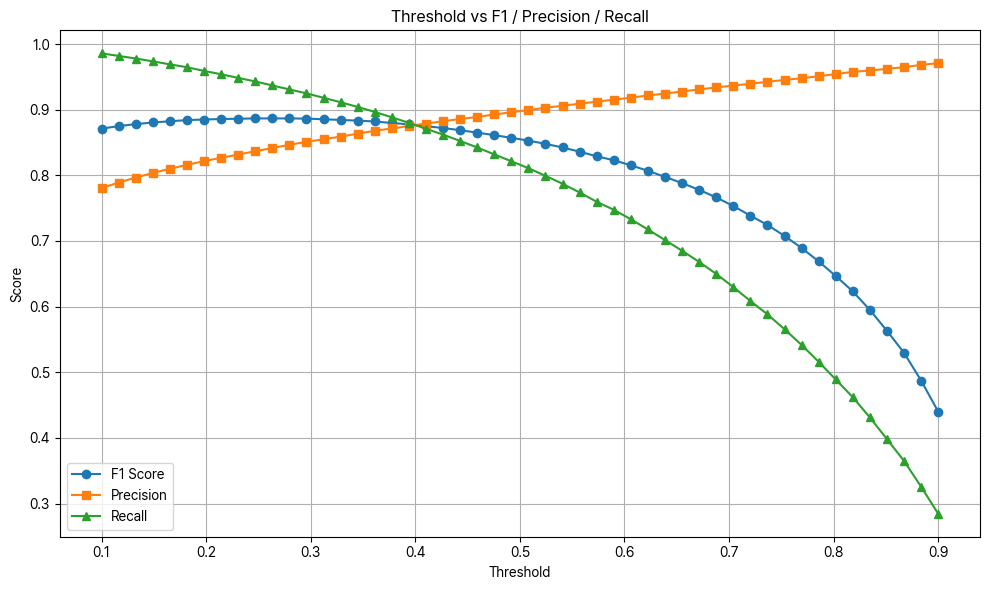

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# D 클래스 확률 추출
y_proba = model.predict_proba(X_val)[:, 1]  # ← model, X_val은 이미 학습된 객체여야 함

# threshold 범위
thresholds = np.linspace(0.1, 0.9, 50)

# 각 지표 계산
f1_scores = []
precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))
    precision_scores.append(precision_score(y_val, y_pred_thresh))
    recall_scores.append(recall_score(y_val, y_pred_thresh))

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='s')
plt.plot(thresholds, recall_scores, label='Recall', marker='^')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs F1 / Precision / Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 앙상블 시도

### Stacking Try

In [88]:
# 예시 리스트 (train/val 공통적용 가능)
baseline_features = cd_top_features
feature_with_derived = cd_top_features + cd_derive
feature_with_vif = final_features_vif  # VIF 제거 후 변수 리스트

# 함수: 예측 확률값 저장
def train_and_predict_proba(X, y, features, model_name='model'):
    X_train, X_val, y_train, y_val = train_test_split(X[features], y, test_size=0.2, stratify=y, random_state=42)
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    model = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train_res, y_train_res)

    val_proba = model.predict_proba(X_val)[:, 1]
    return val_proba, y_val


In [ ]:
X_all = df[df['Segment'].isin(['C', 'D'])]
y_all = LabelEncoder().fit_transform(X_all['Segment'])

# 예측 확률값 수집
proba_baseline, y_val_meta = train_and_predict_proba(X_all, y_all, baseline_features, 'baseline')
proba_derived, _ = train_and_predict_proba(X_all, y_all, feature_with_derived, 'derived')
proba_vif, _ = train_and_predict_proba(X_all, y_all, feature_with_vif, 'vif')


# stacking input 구성
X_meta = pd.DataFrame({
    'baseline': proba_baseline,
    'derived': proba_derived,
    'vif': proba_vif
})

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import pandas as pd


# 메타모델용 train/val 분리
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_meta, y_val_meta, test_size=0.2, stratify=y_val_meta, random_state=42
)

# 메타 모델 정의
meta_models = {
    "Logistic": LogisticRegression(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    ),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, task_type="GPU", random_state=42)
}

# 결과 저장
results = []

# 학습 및 평가
for name, model in meta_models.items():
    model.fit(X_train_meta, y_train_meta)
    y_pred = model.predict(X_val_meta)
    macro_f1 = f1_score(y_val_meta, y_pred, average='macro')
    results.append((name, round(macro_f1, 4)))

# 결과 정리
results_df = pd.DataFrame(results, columns=["Model", "Macro_F1"]).sort_values(by="Macro_F1", ascending=False)
print(results_df)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:15:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


          Model  Macro_F1
0      Logistic    0.7770
4           SVM    0.7744
5      CatBoost    0.7732
2       XGBoost    0.7726
1  RandomForest    0.7598
3           KNN    0.7488


### Voting 방식 적용

In [94]:
# 전체 C/D 데이터셋 준비
X_all = df[df['Segment'].isin(['C', 'D'])]
y_all = LabelEncoder().fit_transform(X_all['Segment'])

# ✅ 모든 모델이 사용할 동일한 validation 셋 분리
X_train_fixed, X_val_fixed, y_train_fixed, y_val_fixed = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

In [95]:
def predict_proba_on_fixed_val(X_train, y_train, X_val, features):
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train[features], y_train)
    
    model = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train_res, y_train_res)
    
    return model.predict_proba(X_val[features])[:, 1]

In [96]:
proba_baseline = predict_proba_on_fixed_val(X_train_fixed, y_train_fixed, X_val_fixed, cd_top_features)
proba_derived  = predict_proba_on_fixed_val(X_train_fixed, y_train_fixed, X_val_fixed, cd_top_features + cd_derive)
proba_vif      = predict_proba_on_fixed_val(X_train_fixed, y_train_fixed, X_val_fixed, final_features_vif)

In [97]:
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# Soft Voting
proba_soft = (proba_baseline + proba_derived + proba_vif) / 3
y_pred_soft = (proba_soft > 0.5).astype(int)

# Weighted Voting
proba_weighted = 0.5 * proba_baseline + 0.3 * proba_derived + 0.2 * proba_vif
y_pred_weighted = (proba_weighted > 0.5).astype(int)

# 비교
report_soft = classification_report(y_val_fixed, y_pred_soft, target_names=['C', 'D'], output_dict=True)
report_weighted = classification_report(y_val_fixed, y_pred_weighted, target_names=['C', 'D'], output_dict=True)

comparison = pd.DataFrame({
    "Model": ["Soft Voting", "Weighted Voting"],
    "Macro_F1": [
        round(f1_score(y_val_fixed, y_pred_soft, average='macro'), 4),
        round(f1_score(y_val_fixed, y_pred_weighted, average='macro'), 4)
    ],
    "C_F1": [
        round(report_soft['C']['f1-score'], 4),
        round(report_weighted['C']['f1-score'], 4)
    ],
    "D_F1": [
        round(report_soft['D']['f1-score'], 4),
        round(report_weighted['D']['f1-score'], 4)
    ]
})

print(comparison)

             Model  Macro_F1    C_F1    D_F1
0      Soft Voting    0.7781  0.6827  0.8734
1  Weighted Voting    0.7794  0.6833  0.8754


- Weighted Voting 이 조금 더 나은 결과 보여줌 (0.779) <- Stacking (Logistic) : 0.777

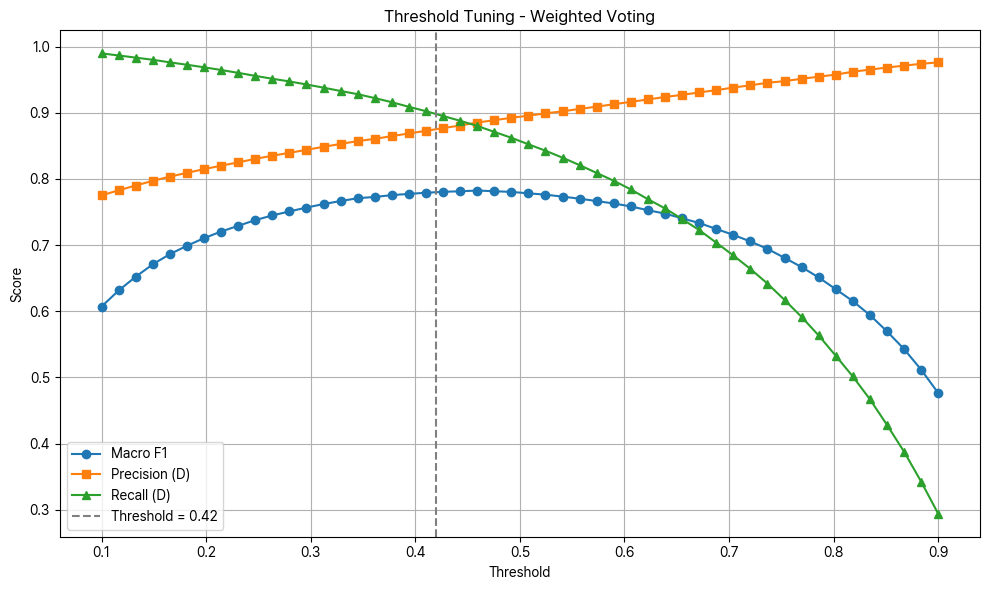

In [98]:
# threshold tuning 그래프
thresholds = np.linspace(0.1, 0.9, 50)
f1s, precisions, recalls = [], [], []

for t in thresholds:
    preds = (proba_weighted > t).astype(int)
    f1s.append(f1_score(y_val_fixed, preds, average='macro'))
    precisions.append(precision_score(y_val_fixed, preds))
    recalls.append(recall_score(y_val_fixed, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label="Macro F1", marker='o')
plt.plot(thresholds, precisions, label="Precision (D)", marker='s')
plt.plot(thresholds, recalls, label="Recall (D)", marker='^')
plt.axvline(x=0.42, color='gray', linestyle='--', label="Threshold = 0.42")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Weighted Voting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
import numpy as np
from sklearn.metrics import f1_score

# threshold 후보 범위 설정
thresholds = np.linspace(0.1, 0.9, 100)

# 성능 저장 리스트
f1s = []

# 각 threshold에서 macro f1 계산
for t in thresholds:
    preds = (proba_weighted > t).astype(int)
    f1s.append(f1_score(y_val_fixed, preds, average='macro'))

# 최적 threshold 탐색
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"✅ 최적 threshold: {round(best_threshold, 4)}")
print(f"🎯 해당 macro F1-score: {round(best_f1, 4)}")

✅ 최적 threshold: 0.4636
🎯 해당 macro F1-score: 0.7824


macro F1 (0.63 -> 0.78)